# M1 Research Computing Coursework

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization # imports our layers we want to use
from tensorflow.keras.utils import to_categorical #some function for data preparation
from tensorflow.keras.callbacks import ModelCheckpoint #checkpoints used to keep track of best model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

In [2]:
np.random.seed(270103) # Set random seed for reproducibility

## Q1

In [3]:
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_val = x_train[48000:]
y_val = y_train[48000:]

x_train = x_train[:48000]
y_train = y_train[:48000]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (48000, 28, 28)
48000 train samples
12000 validation samples
10000 test samples


In [4]:
def gen_dataset(inputdata, inputlabels, numsamples):
    """
    Function to construct the dataset of 56x28 images

    Parameters
    - inputdata: data which to generate the combined image dataset from (train, validation or test)
    - inputlabels: the corresponding labels
    - numsamples: number of samples desired

    Returns
    - np.array(outputdata): the set of 56x28 images
    - np.array(outputlabels): the labels of the 56x28 images
    """

    inputsize = len(inputdata)
    outputdata = []
    outputlabels = []

    for _ in range(numsamples):

        index1, index2 = np.random.choice(np.arange(inputsize), size = 2) # two random indices
        
        outputdata.append( np.vstack( (inputdata[index1], inputdata[index2]) ) ) # join the two images corresponding to these indices 
        outputlabels.append( inputlabels[index1] + inputlabels[index2] ) # add the labels corresponding to the indices to get the sum

    return np.array(outputdata), np.array(outputlabels)

def plot_data_hist(traindata, valdata, testdata):
    """
    Function to plot the histogram of the data

    Parameters
    - traindata: training data
    - valdata: validation data
    - testdata: test data
    """

    traincounts = [np.count_nonzero(traindata == i) for i in range(19)]
    valcounts = [np.count_nonzero(valdata == i) for i in range(19)]
    testcounts = [np.count_nonzero(testdata == i) for i in range(19)]

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    ax[0].bar(range(19), traincounts, color='blue', edgecolor='black')
    ax[1].bar(range(19), valcounts, color='blue', edgecolor='black')
    ax[2].bar(range(19), testcounts, color='blue', edgecolor='black')

    fig.suptitle('Histogram of Integer Occurrences')
    ax[0].set_title("Train set")
    ax[1].set_title("Validation set")
    ax[2].set_title("Test set")
    ax[0].set_xlabel('Integer Value')
    ax[1].set_xlabel('Integer Value')
    ax[2].set_xlabel('Integer Value')
    ax[0].set_ylabel('Frequency')
    plt.xticks(range(19)) 
    plt.show()

new_x_train shape: (100000, 56, 28)
100000 train samples
25000 validation samples
25000 test samples


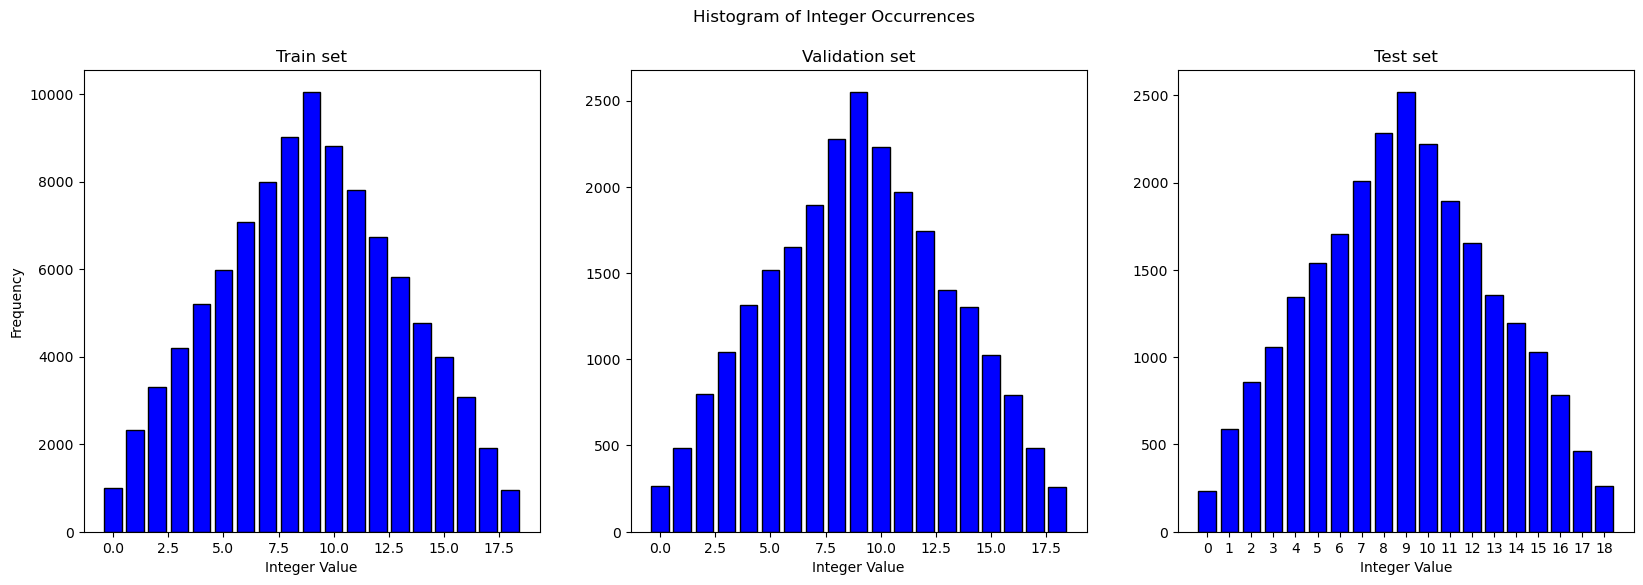

In [5]:
num_classes = 19

new_x_train, new_y_train = gen_dataset(x_train, y_train, 100000)
new_x_val, new_y_val = gen_dataset(x_val, y_val, 25000)
new_x_test, new_y_test = gen_dataset(x_test, y_test, 25000)

print('new_x_train shape:', new_x_train.shape)
print(new_x_train.shape[0], 'train samples')
print(new_x_val.shape[0], 'validation samples')
print(new_x_test.shape[0], 'test samples')

plot_data_hist(new_y_train, new_y_val, new_y_test)

In [6]:
# one-hot encoding the labels
new_y_train = to_categorical(new_y_train, num_classes)
new_y_val = to_categorical(new_y_val, num_classes)
new_y_test = to_categorical(new_y_test, num_classes)

## Q2

In [7]:
# Load validation accuracy list from CSV
df_loaded_nn = pd.read_csv("../data/nn_validation_accuracies.csv")
loaded_nn_val_acc = df_loaded_nn["val_acc"].tolist()

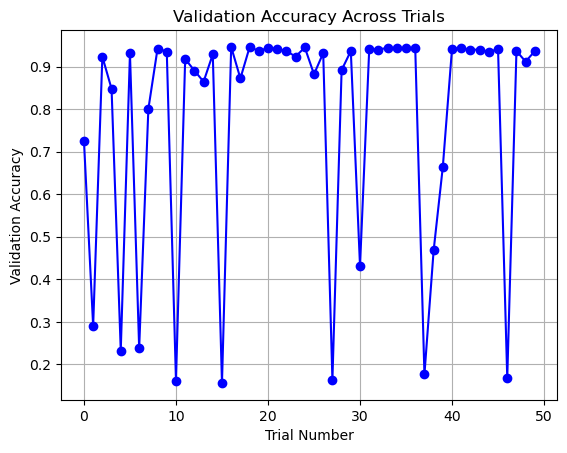

In [8]:
# Plot validation accuracy across trials
plt.plot(loaded_nn_val_acc, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy Across Trials')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.grid()

plt.savefig('../data/optuna_val_accuracy.jpg')
plt.show()

In [9]:
# Load optimal hyperparameters from CSV
df_loaded_opt_nn = pd.read_csv('../data/nn_opt_hyperparams.csv')

# Reconstruct the list with original data types
loaded_nn_opt_hyperparams = [
    eval(dtype)(value) if dtype in ['int', 'float'] else value
    for value, dtype in zip(df_loaded_opt_nn['hyperparams'], df_loaded_opt_nn['type'])
]
print(loaded_nn_opt_hyperparams)

[5, 'sigmoid', 0.2984215744011278, 418, 0.0007565995480433036]


In [10]:
opt_nn_model = Sequential()
opt_nn_model.add(Flatten(input_shape=(56, 28)))

num_layers, activation, dropout_rate, units, learning_rate = loaded_nn_opt_hyperparams

for i in range(num_layers):

    if i == num_layers - 1:
        opt_nn_model.add(Dense(units=units, activation=activation, name='embedding_layer'))

    else:
        opt_nn_model.add(Dense(units=units, activation=activation)) 

    opt_nn_model.add(BatchNormalization())                      
    opt_nn_model.add(Dropout(rate=dropout_rate))   

opt_nn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
opt_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

opt_nn_model.summary()


/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-17 17:39:28.644650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-17 17:39:28.644688: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-17 17:39:28.644696: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-17 17:39:28.644715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-17 17:39:28.644731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 418)            │       655,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 418)            │         1,672 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 418)            │       175,142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 418)            │         1,672 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 418)            │       175,142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 418)            │         1,672 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 418)            │       175,142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 418)            │         1,672 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Dense)         │ (None, 418)            │       175,142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 418)            │         1,672 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 19)             │         7,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,372,731 (5.24 MB)

 Trainable params: 1,368,551 (5.22 MB)

 Non-trainable params: 4,180 (16.33 KB)

In [11]:
# keeping the best model on the test/validation data.

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('../model/best_nn_model.keras', 
                             monitor='val_accuracy',  
                             save_best_only=True, 
                             mode='max',  
                             verbose=1)

history_opt_nn_model = opt_nn_model.fit(new_x_train, new_y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          callbacks=[checkpoint],
          validation_data=(new_x_val, new_y_val))

Epoch 1/20


2024-12-17 17:39:30.771493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1970 - loss: 2.7354
Epoch 1: val_accuracy improved from -inf to 0.65180, saving model to ../model/best_nn_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.1972 - loss: 2.7348 - val_accuracy: 0.6518 - val_loss: 1.1470
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5815 - loss: 1.3590
Epoch 2: val_accuracy improved from 0.65180 to 0.79228, saving model to ../model/best_nn_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.5815 - loss: 1.3589 - val_accuracy: 0.7923 - val_loss: 0.7046
Epoch 3/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7408 - loss: 0.8892
Epoch 3: val_accuracy improved from 0.79228 to 0.85252, saving model to ../model/best_nn_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7409 - loss: 0.8891 - val_accuracy: 0.8525 - val_loss: 0.5206
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - loss: 0.6603
Epoch 

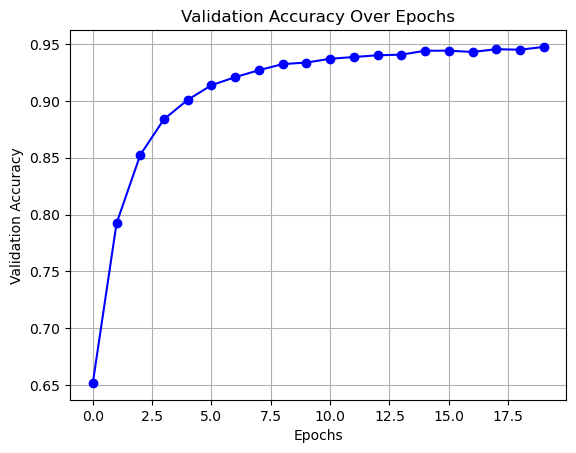

In [12]:
nn_val_accuracies = history_opt_nn_model.history['val_accuracy']

# Plot validation accuracies across training
plt.plot(nn_val_accuracies, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid()

plt.savefig('../data/best_nn_acc.jpg')
plt.show()

In [13]:
# Load the model
best_nn_model = tf.keras.models.load_model('../model/best_nn_model.keras')
print("Model loaded from ../model/best_nn_model.keras")

# Save the weights 
best_nn_model.save_weights('../weights/best_nn_weights.weights.h5')
print("Weights saved")

# Evaluate the loaded model on test set
loss, accuracy = best_nn_model.evaluate(new_x_test, new_y_test)

Model loaded from ../model/best_nn_model.keras
Weights saved
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9468 - loss: 0.2735


## Q3

In [14]:
# Flatten each image
flat_x_train = new_x_train.reshape(new_x_train.shape[0], -1)  
flat_x_val = new_x_val.reshape(new_x_val.shape[0], -1)  
flat_x_test = new_x_test.reshape(new_x_test.shape[0], -1)  

# Convert one-hot encoding back to integer labels
int_y_train = np.argmax(new_y_train, axis=1) 
int_y_val = np.argmax(new_y_val, axis=1)  
int_y_test = np.argmax(new_y_test, axis=1)  

### Random forest

In [15]:
# Load random forest validation accuracy list from CSV
df_loaded_rf = pd.read_csv("../data/rf_validation_accuracies.csv")
loaded_rf_val_acc = df_loaded_rf["val_acc"].tolist()

In [16]:
# Load optimal hyperparameters from CSV
df_loaded_opt_rf = pd.read_csv('../data/opt_hyperparams_rf.csv')

# Reconstruct the list with original data types
loaded_rf_opt_hyperparams = [
    eval(dtype)(value) if dtype in ['int', 'float'] else value
    for value, dtype in zip(df_loaded_opt_rf['hyperparams'], df_loaded_opt_rf['type'])
]
print(loaded_rf_opt_hyperparams)

[285, 196]


In [17]:
n_estimators, max_depth = loaded_rf_opt_hyperparams

RndFrstClass_best = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth) # construct random forest object with optimal hyperparameters
RndFrstClass_best.fit(flat_x_train, int_y_train) 

RandomForestClassifier(max_depth=196, n_estimators=285)

In [18]:
best_rf_score = RndFrstClass_best.score(flat_x_test, int_y_test)
print('Score: ', best_rf_score)

Score:  0.81664


### SVM

In [19]:
# Load svm validation accuracy list from CSV
df_loaded_svm = pd.read_csv("../data/svm_validation_accuracies.csv")
loaded_svm_val_acc = df_loaded_svm["val_acc"].tolist()

In [20]:
# Load optimal svm hyperparams from CSV
df_loaded_opt_svm = pd.read_csv('../data/opt_hyperparams_svm.csv')

# Reconstruct the list with original data types
loaded_svm_opt_hyperparams = [
    eval(dtype)(value) if dtype in ['int', 'float'] else value
    for value, dtype in zip(df_loaded_opt_svm['hyperparams'], df_loaded_opt_svm['type'])
]
print(loaded_svm_opt_hyperparams)

[27.572037319938246, 0.0130562874977502]


In [21]:
c, gamma = loaded_svm_opt_hyperparams

svcClass_best = SVC(C=c, gamma=gamma) # construct svm object with optimal hyperparameters
svcClass_best.fit(flat_x_train[:5000], int_y_train[:5000])

SVC(C=27.572037319938246, gamma=0.0130562874977502)

In [22]:
best_svm_score = svcClass_best.score(flat_x_test[:5000], int_y_test[:5000])
print('Score: ', best_svm_score)

Score:  0.5836


### Comparing the models

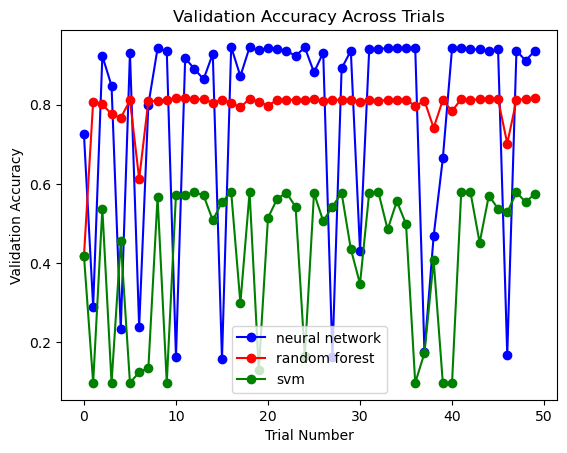

In [23]:
# Plot validation accuracy across hyperparam tuning trials for each model
plt.plot(loaded_nn_val_acc, marker='o', linestyle='-', color='b', label='neural network')
plt.plot(loaded_rf_val_acc, marker='o', linestyle='-', color='red', label='random forest')
plt.plot(loaded_svm_val_acc, marker='o', linestyle='-', color='green', label='svm')
plt.title('Validation Accuracy Across Trials')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.savefig('../data/model_comparison.jpg')
plt.show()

In [24]:
# comparison of best model accuracies 
best_nn_score = accuracy

print("Neural network: ", best_nn_score)
print("Random forest: ", best_rf_score)
print("SVM: ", best_svm_score)

Neural network:  0.9484800100326538
Random forest:  0.81664
SVM:  0.5836


## Q4

In [25]:
def eval_seq_acc(seq_model, numsamples):
    """
    Function to evaluate the accuracy of the single linear classifier which is applied on the two images sequentially.

    Parameters
    - seq_model: the linear classifier which is used for sequential application on the images
    - numsamples: the number of data samples

    Returns
    - accuracy: the accuracy when the linear classifier is applied on the two images sequentially
    """

    numcorrect = 0

    for i in range(numsamples):

        image = flat_x_test[i].reshape(56,28)

        # split the 56x28 image into two 28x28 images corresponding to the top and bottom number in the 56x28 image
        top_number = image[:28,:]
        bottom_number = image[28:,:]

        num1 = seq_model.predict(top_number.reshape(1,-1))[0]
        num2 = seq_model.predict(bottom_number.reshape(1,-1))[0]

        sum = num1 + num2

        if sum == int_y_test[i]:

            numcorrect += 1
    
    accuracy = numcorrect/numsamples

    return accuracy

In [ ]:
sequential_accuracy = []
combined_accuracy = []

sample_sizes = [50, 100, 500, 1000, 2500, 5000]

for size in sample_sizes:

        combined = LogisticRegression(C=1, multi_class='multinomial', penalty='l2', solver='saga', tol=0.01, class_weight='balanced', max_iter=2500) # balanced class_weight to take into account different number of examples in each class
        # fit data
        combined.fit(flat_x_train[:size], int_y_train[:size])
        # compute accuracy for combined
 
        combined_score = combined.score(flat_x_test, int_y_test)
        sequential = LogisticRegression(C=1, multi_class='multinomial', penalty='l2',solver='saga', tol=0.01, max_iter=2500) 
        # fit data
        sequential.fit(np.array(x_train).reshape((48000,784))[:size], y_train[:size])
        # compute accuracy for sequential
  
        sequential_score = eval_seq_acc(sequential, flat_x_test.shape[0])

        sequential_accuracy.append(sequential_score)
        combined_accuracy.append(combined_score)

/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to

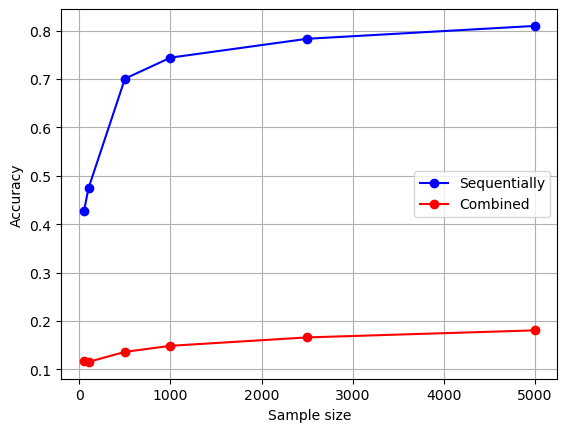

In [27]:
plt.plot(sample_sizes, sequential_accuracy, marker='o', label='Sequentially', color='blue')
plt.plot(sample_sizes, combined_accuracy, marker='o', label='Combined', color='red')
plt.xlabel('Sample size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('../data/sequentialvscombined.jpg')
plt.show()

## Q5

#### t-SNE of classes in embedding layer

In [ ]:
# Create a submodel to output the embedding layer
embedding_model = Model(inputs=best_nn_model.inputs, outputs=best_nn_model.get_layer("embedding_layer").output) 

# Extract embeddings for the training data
X_train_embeddings = embedding_model.predict(new_x_train)  # Shape: (100000, 128)

/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 56, 28))
  warnings.warn(msg)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [ ]:
# Apply t-SNE
tsne_embedding = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_embedded = tsne_embedding.fit_transform(X_train_embeddings[:5000])  # Use a subset for speed

# Corresponding labels
y_subset = int_y_train[:5000]

/Users/panosantonopoulos/anaconda3/envs/M1_coursework_conda_environment/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


#### t-SNE on input dataset

In [30]:
tsne_input = TSNE(n_components=2, perplexity=55, random_state=1)
X_inputset = tsne_input.fit_transform(flat_x_train[:5000])  # Use a subset for efficiency

Text(0.5, 0, 't-SNE Dimension 1')

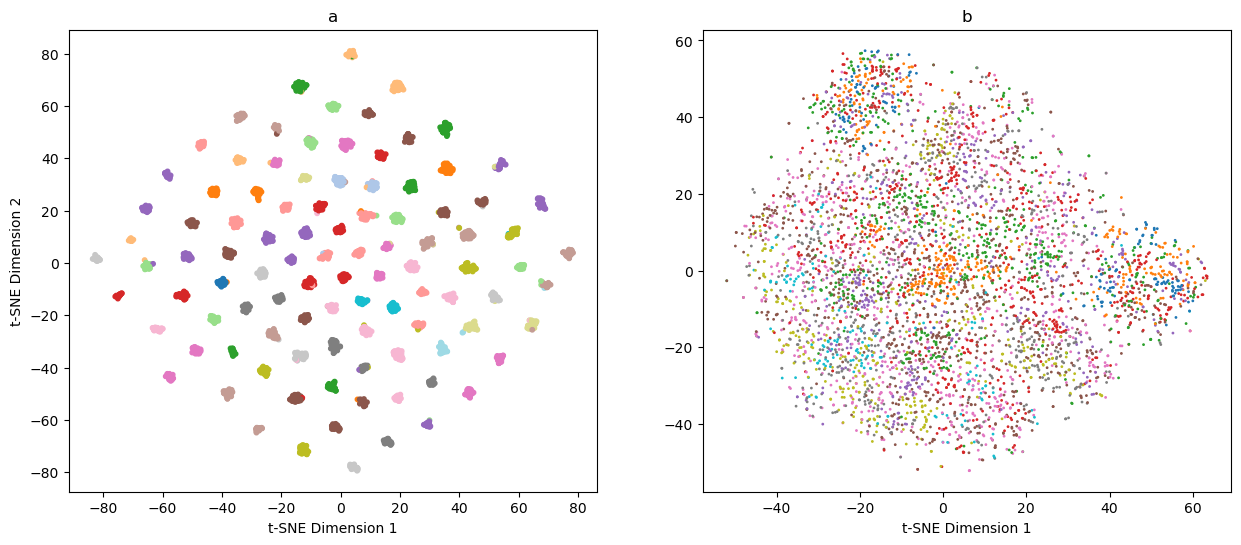

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_subset, cmap='tab20', s=10)
ax[0].set_title("a") # embedding layer
ax[0].set_xlabel("t-SNE Dimension 1")
ax[0].set_ylabel("t-SNE Dimension 2")

ax[1].scatter(X_inputset[:, 0], X_inputset[:, 1], c=int_y_train[:5000].astype(int), cmap='tab10', s=1)
ax[1].set_title("b") # input dataset
ax[1].set_xlabel("t-SNE Dimension 1")